In [1]:
import os
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import SwitchCaseOp
from qiskit.result import ProbDistribution
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_distribution

from qiskit_aer import AerSimulator

from qiskit_ibm_runtime.fake_provider import FakeValenciaV2
from qiskit_ibm_runtime import SamplerV2

import matplotlib.pyplot as plt

from utils import export_data_json, generate_output_dir, generate_full_file_path

In [2]:
OUTPUT_PATH = os.path.join(os.getcwd(), 'dynamic-circuit-tests')
generate_output_dir(OUTPUT_PATH)

/home/alexandre/projects/scientific-research-2-qec-and-qem/src/dynamic-circuit-tests already exists!


In [3]:
fake_backend = FakeValenciaV2()
fake_backend.target.add_instruction(SwitchCaseOp, name="switch_case")
backend = AerSimulator.from_backend(fake_backend)

In [4]:
sampler = SamplerV2(backend=backend)

In [5]:
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)

In [6]:
N_QUBITS = 3

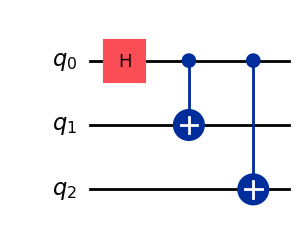

Default Circuit DEPTH: 3


In [7]:
qc = QuantumCircuit(N_QUBITS)
qc.h(0)
qc.cx(0,1)
qc.cx(0,2)
display(qc.draw('mpl', filename=generate_full_file_path(OUTPUT_PATH, "GHZ-circuit.png")))
print(f"Default Circuit DEPTH: {qc.depth()}")

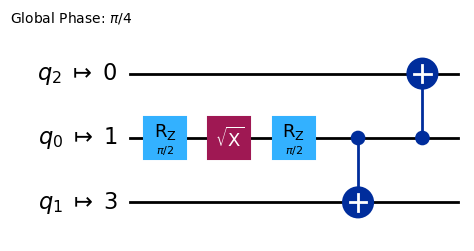

ISA Circuit DEPTH: 5


In [8]:
isa_circuit = pm.run(qc)
display(isa_circuit.draw('mpl', idle_wires=False, filename=generate_full_file_path(OUTPUT_PATH, "ISA-GHZ-circuit.png")))
print(f"ISA Circuit DEPTH: {isa_circuit.depth()}")

In [9]:
SHOTS = 1000

In [10]:
isa_circuit_cp = isa_circuit.copy()
isa_circuit_cp.measure_all()
results = sampler.run([isa_circuit_cp], shots=SHOTS).result()[0]

In [11]:
counts = results.data.meas.get_counts()
export_data_json(counts, generate_full_file_path(OUTPUT_PATH, "noisy-outputs.json"))

saving /home/alexandre/projects/scientific-research-2-qec-and-qem/src/dynamic-circuit-tests/noisy-outputs.json...


In [12]:
quasi = ProbDistribution(counts).binary_probabilities(num_bits=N_QUBITS)

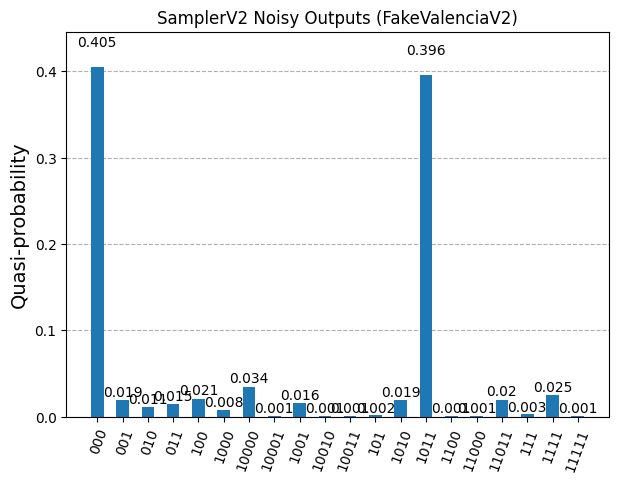

In [13]:
fig = plot_distribution(quasi, title="SamplerV2 Noisy Outputs (FakeValenciaV2)")
fig.savefig(generate_full_file_path(OUTPUT_PATH, "sampler-noisy-ouputs.png"))
display(fig)

---

In [14]:
qubits = QuantumRegister(N_QUBITS, name="q")
mid_meas = ClassicalRegister(N_QUBITS, name="mid")
final_meas = ClassicalRegister(N_QUBITS, name="meas")

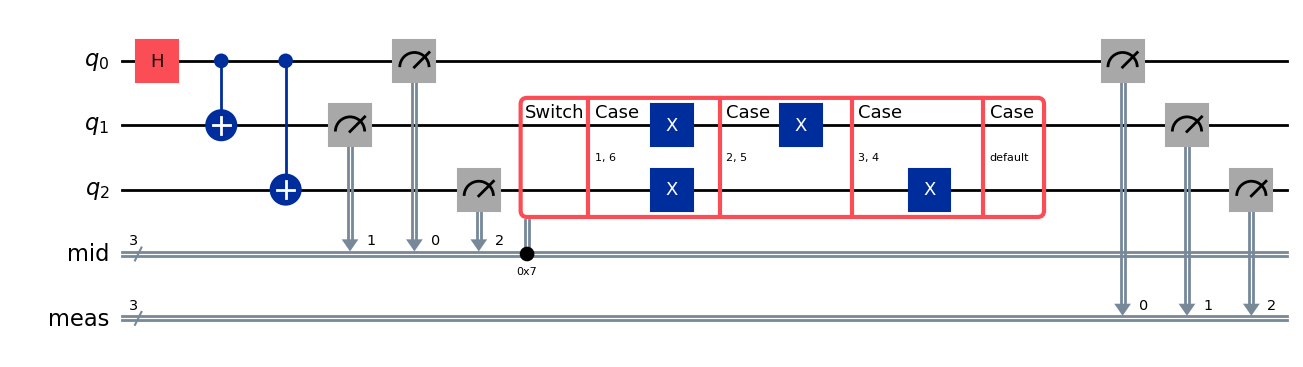

Default Circuit DEPTH: 6


In [15]:
qc = QuantumCircuit(qubits, mid_meas, final_meas)
qc.h(qubits[0])
qc.cx(qubits[0], qubits[1])
qc.cx(qubits[0], qubits[2])

qc.measure(qubits, mid_meas)

with qc.switch(mid_meas) as case:
    with case(1,6): #001 and 110
        qc.x([qubits[1], qubits[2]])

    with case(2,5): #010 and 101
        qc.x(qubits[1])

    with case(3,4): #011 and 100
        qc.x(qubits[2])
    
    with case(case.DEFAULT): #000 and 111
        pass
        
qc.measure(qubits, final_meas)

display(qc.draw('mpl', filename=generate_full_file_path(OUTPUT_PATH, "GHZ-dynamic-circuit.png")))
print(f"Default Circuit DEPTH: {qc.depth()}")

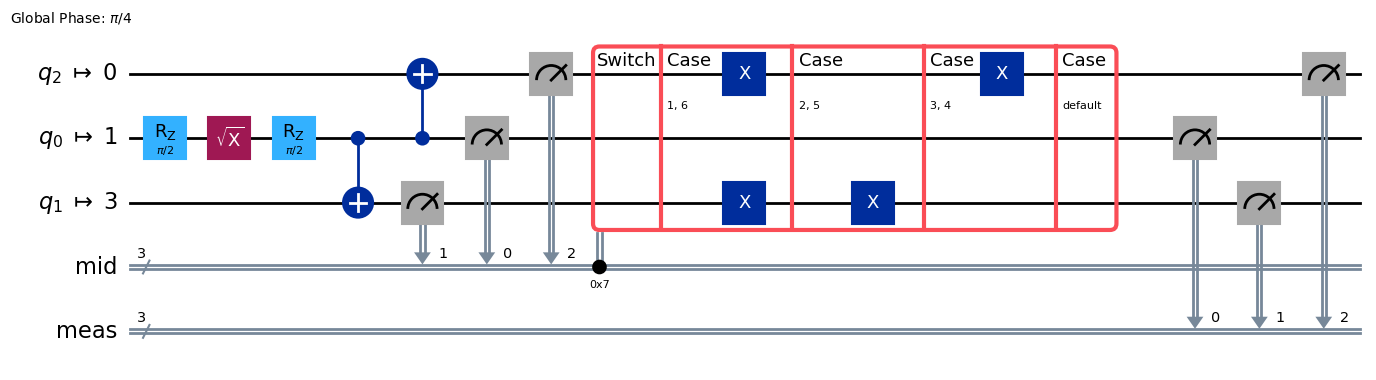

ISA Circuit DEPTH: 8


In [16]:
isa_circuit = pm.run(qc)
display(isa_circuit.draw('mpl', idle_wires=False, filename=generate_full_file_path(OUTPUT_PATH, "ISA-GHZ-dynamic-circuit.png")))
print(f"ISA Circuit DEPTH: {isa_circuit.depth()}")

In [17]:
results = sampler.run([isa_circuit_cp], shots=SHOTS).result()[0]

In [18]:
counts = results.data.meas.get_counts()
export_data_json(counts, generate_full_file_path(OUTPUT_PATH, "corrected-outputs.json"))

saving /home/alexandre/projects/scientific-research-2-qec-and-qem/src/dynamic-circuit-tests/corrected-outputs.json...


In [19]:
quasi = ProbDistribution(counts).binary_probabilities(num_bits=N_QUBITS)

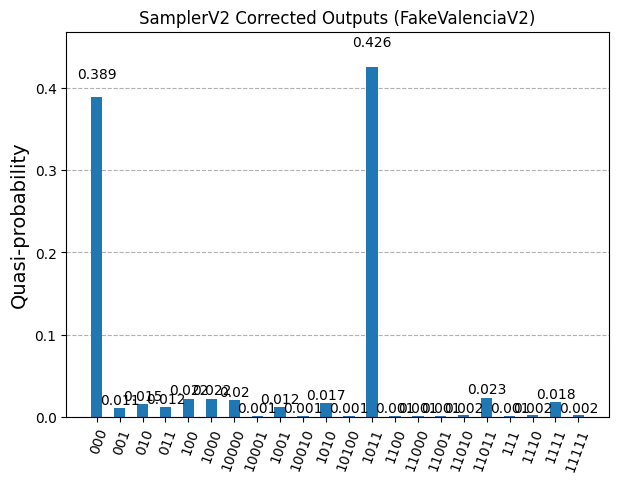

In [20]:
fig = plot_distribution(quasi, title="SamplerV2 Corrected Outputs (FakeValenciaV2)")
fig.savefig(generate_full_file_path(OUTPUT_PATH, "sampler-noisy-ouputs.png"))
display(fig)